# Binocular SFM

## Installing and Loading Libraries

Installing low version of openCV for utilizing the SIFT module which is not available without license in the upgraded version of openCV

In [ ]:
!pip uninstall opencv-python -y
# downgrade OpenCV a bit since some none-free features are not avilable
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

## Loading Data

### Cloning data github repository

In [2]:
!git clone https://github.com/rawakash66/ME683A-SFM

Cloning into 'ME683A-SFM'...
remote: Enumerating objects: 205, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 205 (delta 3), reused 0 (delta 0), pack-reused 139
Receiving objects: 100% (205/205), 90.10 MiB | 24.33 MiB/s, done.
Resolving deltas: 100% (52/52), done.


### Moving inside folder

In [3]:
%cd ME683A-SFM

/content/ME683A-SFM


### Loading images from folder

In [4]:
imageFolder = 'frames3/'
validFile = ['jpg','png','JPG']
H, W = (1499, 1932)
listArchives = os.listdir(imageFolder)
listArchives.sort(reverse = False)
validImages = filter(lambda x: x.split('.')[-1] in validFile, listArchives)
listImages = list(map(lambda x: cv2.imread(imageFolder + x), validImages))
listImages = list(map(lambda x: cv2.resize(x,(W,H)), listImages))

## Visualize Data

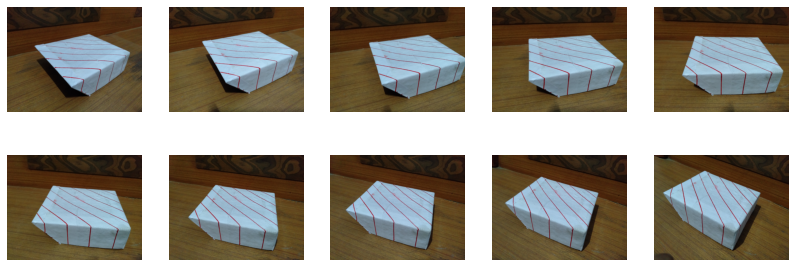

In [6]:
fig, axs = plt.subplots(2, 5, figsize=(14,5))

for i in range(10):
  axs[i//5, i%5].imshow(cv2.cvtColor(listImages[i], cv2.COLOR_BGR2RGB))
  axs[i//5, i%5].axis('off')

plt.show()

## Correspondence finding

Function for correspondence detection using in-build SIFT module from openCV and homography to detect good matching points between two images.

In [7]:
def find_correspondence_points(img1, img2):
    sift = cv2.xfeatures2d.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(
        cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), None)
    kp2, des2 = sift.detectAndCompute(
        cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), None)

    # Find point matches
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # Apply Lowe's SIFT matching ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)

    src_pts = np.asarray([kp1[m.queryIdx].pt for m in good])
    dst_pts = np.asarray([kp2[m.trainIdx].pt for m in good])

    # Constrain matches to fit homography
    retval, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 100.0)
    mask = mask.ravel()

    # We select only inlier points
    pts1 = src_pts[mask == 1]
    pts2 = dst_pts[mask == 1]

    return pts1.T, pts2.T

## Processor Functions

Functions to read the parameter matrix, convert the homogenous to cartesian and vice-versa to process the points.

In [8]:
def cart2hom(arr):
    """ Convert catesian to homogenous points by appending a row of 1s
    :param arr: array of shape (num_dimension x num_points)
    :returns: array of shape ((num_dimension+1) x num_points) 
    """
    if arr.ndim == 1:
        return np.hstack([arr, 1])
    return np.asarray(np.vstack([arr, np.ones(arr.shape[1])]))


def hom2cart(arr):
    """ Convert homogenous to catesian by dividing each row by the last row
    :param arr: array of shape (num_dimension x num_points)
    :returns: array of shape ((num_dimension-1) x num_points) iff d > 1 
    """
    # arr has shape: dimensions x num_points
    num_rows = len(arr)
    if num_rows == 1 or arr.ndim == 1:
        return arr

    return np.asarray(arr[:num_rows - 1] / arr[num_rows - 1])

## Structure Functions

Functions for creating the epipoles, epipolar lines, Projection matrices, linear triangulation, scaling and normalization of 3D coordinates

In [9]:
def reconstruct_points(p1, p2, m1, m2):
    num_points = p1.shape[1]
    res = np.ones((4, num_points))

    for i in range(num_points):
        res[:, i] = reconstruct_one_point(p1[:, i], p2[:, i], m1, m2)

    return res


def reconstruct_one_point(pt1, pt2, m1, m2):
    """
        pt1 and m1 * X are parallel and cross product = 0
        pt1 x m1 * X  =  pt2 x m2 * X  =  0
    """
    A = np.vstack([
        np.dot(skew(pt1), m1),
        np.dot(skew(pt2), m2)
    ])
    U, S, V = np.linalg.svd(A)
    P = np.ravel(V[-1, :4])

    return P / P[3]


def linear_triangulation(p1, p2, m1, m2):
    """
    Linear triangulation (Hartley ch 12.2 pg 312) to find the 3D point X
    where p1 = m1 * X and p2 = m2 * X. Solve AX = 0.
    :param p1, p2: 2D points in homo. or catesian coordinates. Shape (3 x n)
    :param m1, m2: Camera matrices associated with p1 and p2. Shape (3 x 4)
    :returns: 4 x n homogenous 3d triangulated points
    """
    num_points = p1.shape[1]
    res = np.ones((4, num_points))

    for i in range(num_points):
        A = np.asarray([
            (p1[0, i] * m1[2, :] - m1[0, :]),
            (p1[1, i] * m1[2, :] - m1[1, :]),
            (p2[0, i] * m2[2, :] - m2[0, :]),
            (p2[1, i] * m2[2, :] - m2[1, :])
        ])

        _, _, V = np.linalg.svd(A)
        X = V[-1, :4]
        res[:, i] = X / X[3]

    return res


def compute_epipole(F):
    """ Computes the (right) epipole from a
        fundamental matrix F.
        (Use with F.T for left epipole.)
    """
    # return null space of F (Fx=0)
    U, S, V = np.linalg.svd(F)
    e = V[-1]
    return e / e[2]


def plot_epipolar_lines(p1, p2, F, show_epipole=False):
    """ Plot the points and epipolar lines. P1' F P2 = 0 """
    plt.figure(figsize=(10,4))
    plt.suptitle('Epipolar lines', fontsize=16)

    plt.subplot(1, 2, 1)
    # Plot the epipolar lines on img1 with points p2 from the right side
    # L1 = F * p2
    plot_epipolar_line(p1, p2, F, show_epipole)
    plt.subplot(1, 2, 2)
    # Plot the epipolar lines on img2 with points p1 from the left side
    # L2 = F' * p1
    plot_epipolar_line(p2, p1, F.T, show_epipole)


def plot_epipolar_line(p1, p2, F, show_epipole=False):
    """ Plot the epipole and epipolar line F*x=0
        in an image given the corresponding points.
        F is the fundamental matrix and p2 are the point in the other image.
    """
    lines = np.dot(F, p2)
    pad = np.ptp(p1, 1) * 0.01
    mins = np.min(p1, 1)
    maxes = np.max(p1, 1)

    # epipolar line parameter and values
    xpts = np.linspace(mins[0] - pad[0], maxes[0] + pad[0], 100)
    for line in lines.T:
        ypts = np.asarray([(line[2] + line[0] * p) / (-line[1]) for p in xpts])
        valid_idx = ((ypts >= mins[1] - pad[1]) & (ypts <= maxes[1] + pad[1]))
        plt.plot(xpts[valid_idx], ypts[valid_idx], linewidth=1)
        plt.plot(p1[0], p1[1], 'ro')

    if show_epipole:
        epipole = compute_epipole(F)
        plt.plot(epipole[0] / epipole[2], epipole[1] / epipole[2], 'r*')


def skew(x):
    """ Create a skew symmetric matrix *A* from a 3d vector *x*.
        Property: np.cross(x, v) == np.dot(A, v)
    :param x: 3d vector
    :returns: 3 x 3 skew symmetric matrix from *x*
    """
    return np.array([
        [0, -x[2], x[1]],
        [x[2], 0, -x[0]],
        [-x[1], x[0], 0]
    ])


def compute_P(p2d, p3d):
    """ Compute camera matrix from pairs of
        2D-3D correspondences in homog. coordinates.
    """
    n = p2d.shape[1]
    if p3d.shape[1] != n:
        raise ValueError('Number of points do not match.')

    # create matrix for DLT solution
    M = np.zeros((3 * n, 12 + n))
    for i in range(n):
        M[3 * i, 0:4] = p3d[:, i]
        M[3 * i + 1, 4:8] = p3d[:, i]
        M[3 * i + 2, 8:12] = p3d[:, i]
        M[3 * i:3 * i + 3, i + 12] = -p2d[:, i]

    U, S, V = np.linalg.svd(M)
    return V[-1, :12].reshape((3, 4))


def compute_P_from_fundamental(F):
    """ Compute the second camera matrix (assuming P1 = [I 0])
        from a fundamental matrix.
    """
    e = compute_epipole(F.T)  # left epipole
    Te = skew(e)
    return np.vstack((np.dot(Te, F.T).T, e)).T


def compute_P_from_essential(E):
    """ Compute the second camera matrix (assuming P1 = [I 0])
        from an essential matrix. E = [t]R
    :returns: list of 4 possible camera matrices.
    """
    U, S, V = np.linalg.svd(E)

    # Ensure rotation matrix are right-handed with positive determinant
    if np.linalg.det(np.dot(U, V)) < 0:
        V = -V

    # create 4 possible camera matrices (Hartley p 258)
    W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
    P2s = [np.vstack((np.dot(U, np.dot(W, V)).T, U[:, 2])).T,
          np.vstack((np.dot(U, np.dot(W, V)).T, -U[:, 2])).T,
          np.vstack((np.dot(U, np.dot(W.T, V)).T, U[:, 2])).T,
          np.vstack((np.dot(U, np.dot(W.T, V)).T, -U[:, 2])).T]

    return P2s


def correspondence_matrix(p1, p2):
    p1x, p1y = p1[:2]
    p2x, p2y = p2[:2]

    return np.array([
        p1x * p2x, p1x * p2y, p1x,
        p1y * p2x, p1y * p2y, p1y,
        p2x, p2y, np.ones(len(p1x))
    ]).T

    return np.array([
        p2x * p1x, p2x * p1y, p2x,
        p2y * p1x, p2y * p1y, p2y,
        p1x, p1y, np.ones(len(p1x))
    ]).T


def compute_image_to_image_matrix(x1, x2, compute_essential=False):
    """ Compute the fundamental or essential matrix from corresponding points
        (x1, x2 3*n arrays) using the 8 point algorithm.
        Each row in the A matrix below is constructed as
        [x'*x, x'*y, x', y'*x, y'*y, y', x, y, 1]
    """
    A = correspondence_matrix(x1, x2)
    # compute linear least square solution
    U, S, V = np.linalg.svd(A)
    F = V[-1].reshape(3, 3)

    # constrain F. Make rank 2 by zeroing out last singular value
    U, S, V = np.linalg.svd(F)
    S[-1] = 0
    if compute_essential:
        S = [1, 1, 0] # Force rank 2 and equal eigenvalues
    F = np.dot(U, np.dot(np.diag(S), V))

    return F


def scale_and_translate_points(points):
    """ Scale and translate image points so that centroid of the points
        are at the origin and avg distance to the origin is equal to sqrt(2).
    :param points: array of homogenous point (3 x n)
    :returns: array of same input shape and its normalization matrix
    """
    x = points[0]
    y = points[1]
    center = points.mean(axis=1)  # mean of each row
    cx = x - center[0] # center the points
    cy = y - center[1]
    dist = np.sqrt(np.power(cx, 2) + np.power(cy, 2))
    scale = np.sqrt(2) / dist.mean()
    norm3d = np.array([
        [scale, 0, -scale * center[0]],
        [0, scale, -scale * center[1]],
        [0, 0, 1]
    ])

    return np.dot(norm3d, points), norm3d


def compute_normalized_image_to_image_matrix(p1, p2, compute_essential=False):
    """ Computes the fundamental or essential matrix from corresponding points
        using the normalized 8 point algorithm.
    :input p1, p2: corresponding points with shape 3 x n
    :returns: fundamental or essential matrix with shape 3 x 3
    """
    n = p1.shape[1]
    if p2.shape[1] != n:
        raise ValueError('Number of points do not match.')

    # preprocess image coordinates
    p1n, T1 = scale_and_translate_points(p1)
    p2n, T2 = scale_and_translate_points(p2)

    # compute F or E with the coordinates
    F = compute_image_to_image_matrix(p1n, p2n, compute_essential)

    # reverse preprocessing of coordinates
    # We know that P1' E P2 = 0
    F = np.dot(T1.T, np.dot(F, T2))

    return F / F[2, 2]


def compute_fundamental_normalized(p1, p2):
    return compute_normalized_image_to_image_matrix(p1, p2)


def compute_essential_normalized(p1, p2):
    return compute_normalized_image_to_image_matrix(p1, p2, compute_essential=True)

## 3D Projecting

In [10]:
def Object(img1, img2):
    ''''
    Function to get the correspondence points between two images of same object
    and intrinsic camera matrix. 
    ''''
    pts1, pts2 = find_correspondence_points(img1, img2)
    points1 = cart2hom(pts1)
    points2 = cart2hom(pts2)

    fig, ax = plt.subplots(1, 2, figsize=(10,10))
    ax[0].autoscale_view('tight')
    ax[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    ax[0].plot(points1[0], points1[1], 'r.')
    ax[1].autoscale_view('tight')
    ax[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    ax[1].plot(points2[0], points2[1], 'r.')
    plt.show()

    height, width, ch = img1.shape
    #intrinsic = np.array([], dtype=np.float64)
    
    intrinsic = np.array([
        [3801.388, 0, width / 2],
        [0, 3801.388, height / 2],
        [0, 0, 1]])

    return points1, points2, intrinsic

### Looping over the image pairs and 3D points projection

In [11]:
# projection matrix list
P2_list = []

for i in range(len(listImages) - 1):
    points1, points2, intrinsic = Object(listImages[i], listImages[i+1])

    if intrinsic.any():
      # Calculate essential matrix with 2d points.
      # Result will be up to a scale
      # First, normalize points using intrinsic matrix
      points1n = np.dot(np.linalg.inv(intrinsic), points1)
      points2n = np.dot(np.linalg.inv(intrinsic), points2)
      E = compute_essential_normalized(points1n, points2n)
      F = np.dot(np.linalg.inv(intrinsic.T),np.dot(E, np.linalg.inv(intrinsic)))
      F = F/F[2,2]
      print('Essential Matrix\n', E)
      print('Fundamental Matrix\n', F)
    else:
      # Calculate Fundamental matrix with 2d points.
      # Result will be up to a scale
      F = compute_fundamental_normalized(points1, points2)
      print('Fundamental Matrix\n', F)

    # Given we are at camera 1, calculate the parameters for camera 2
    # Using the essential matrix or Fundamental matrix returns 4 possible camera paramters
    P1 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])

    if intrinsic.any():
      P2s = compute_P_from_essential(E)
    else:
      P2s = compute_P_from_fundamental(F)

    print('Camera Projection Matrix', P2s)

    if intrinsic.any():
      ind = -1
      for i, P2 in enumerate(P2s):
          # Find the correct camera parameters
          d1 = reconstruct_one_point(
              points1n[:, 0], points2n[:, 0], P1, P2)

          # Convert P2 from camera view to world view
          P2_homogenous = np.linalg.inv(np.vstack([P2, [0, 0, 0, 1]]))
          d2 = np.dot(P2_homogenous[:3, :4], d1)

          if d1[2] > 0 and d2[2] > 0:
              ind = i

      P2 = np.linalg.inv(np.vstack([P2s[ind], [0, 0, 0, 1]]))[:3, :4]
      tripoints3d = linear_triangulation(points1n, points2n, P1, P2)

      print('Camera Projection Matrix Used in Triangulation', P2)
    else:
      P2 = np.linalg.pinv(np.vstack([P2s, [0, 0, 0, 1]]))[:3, :4]
      tripoints3d = linear_triangulation(points1, points2, P1, P2)

    # store P2 values
    P2_list.append(P2)
    
    ## plot the values
    plot_epipolar_lines(points1, points2, F, True)

    fig = plt.figure(figsize=(10,10))
    fig.suptitle('3D reconstructed', fontsize=16)
    ax = fig.gca(projection='3d')
    ax.plot(tripoints3d[0], tripoints3d[1], tripoints3d[2], 'b.')
    ax.set_xlabel('x axis')
    ax.set_ylabel('y axis')
    ax.set_zlabel('z axis')
    ax.view_init(elev=135, azim=90)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Angle Calculation

In [12]:
## function to get normalized points
def getNormPoints(pointList):
    points = np.array(pointList).T
    points = np.vstack([points, np.ones(points.shape[1])])
    pointsn = np.dot(np.linalg.inv(intrinsic), points)
    return pointsn

## function to calculate angle using vector algebra
## idx parameter is the partition point between the edge points
## idx parameter should be adjusted according to input points
def getAngle(leftPn, rightPn, P1, P2, idx):
    points3d = linear_triangulation(leftPn, rightPn, P1, P2)
    line1 = points3d[:-1,:idx]
    line2 = points3d[:-1,idx:]
    vec1 = np.mean(line1[:,:-1] - line1[:,1:], axis = 1)  # mean vector A
    vec2 = np.mean(line2[:,:-1] - line2[:,1:], axis = 1)  # mean vector B
    theta = np.rad2deg(np.arccos(np.sum(vec1*vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))))
    return theta

### Input points chosen for each image

In [13]:
Points = [[(1099.0, 1035.0), (1339.0, 889.0), (1533.0, 783.0), (1079.0, 1201.0), (1124.0, 1229.0), (1176.0, 1250.0)],
          [(1010.0, 994.0), (1298.0, 872.0), (1545.0, 775.0), (1010.0, 1152.0), (1067.0, 1177.0), (1132.0, 1209.0)],
          [(953.0, 1043.0), (1286.0, 941.0), (1578.0, 864.0), (965.0, 1205.0), (1034.0, 1242.0), (1111.0, 1278.0)],
          [(750.0, 1010.0), (1099.0, 945.0), (1428.0, 893.0), (775.0, 1173.0), (848.0, 1209.0), (933.0, 1258.0)],
          [(617.0, 966.0), (965.0, 950.0), (1314.0, 937.0), (649.0, 1120.0), (726.0, 1173.0), (815.0, 1229.0)],
          [(535.0, 970.0), (860.0, 990.0), (1201.0, 1027.0), (572.0, 1116.0), (649.0, 1173.0), (738.0, 1237.0)],
          [(430.0, 913.0), (710.0, 954.0), (1018.0, 1010.0), (475.0, 1047.0), (544.0, 1104.0), (625.0, 1173.0)],
          [(369.0,820.0),(625.0,881.0),(917.0,958.0),(410.0,950.0),(475.0,1010.0),(552.0,1087.0)],
          [(312.0,731.0),(548.0,812.0),(819.0,921.0),(357.0,864.0),(418.0,929.0),(487.0,1010.0)],
          [(235.0,593.0),(442.0,702.0),(690.0,840.0),(284.0,735.0),(341.0,808.0),(402.0,897.0)]]

### Looping for each image pair

In [14]:
thetas = []

for i in range(len(P2_list)):
    leftn = getNormPoints(Points[i])
    rightn = getNormPoints(Points[i+1])
    theta = getAngle(leftn, rightn, P1, P2_list[i], 3)
    thetas.append(theta)
    
thetas = np.array(thetas)

In [15]:
thetas

array([44.90557298, 49.9455411 , 78.24046463, 43.09524555, 35.21207021,
       16.74201857, 30.39946862, 23.67047912, 39.41681703])

In [16]:
thetas.mean()

40.180853089337326

In [17]:
thetas.std()

16.725294460242807

## Result Tables

### Table for chosen points

In [18]:
Images = ['Image 1','Image 2','Image 3','Image 4','Image 5','Image 6','Image 7','Image 8','Image 9','Image 10']
data = {'Image Number': Images, 'Points Choosen': Points}

df1 = pd.DataFrame(data)

In [19]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
df1 = df1.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
df1 = df1.set_properties(**{'text-align': 'center'}).hide_index()
df1

Image Number,Points Choosen
Image 1,"[(1099.0, 1035.0), (1339.0, 889.0), (1533.0, 783.0), (1079.0, 1201.0), (1124.0, 1229.0), (1176.0, 1250.0)]"
Image 2,"[(1010.0, 994.0), (1298.0, 872.0), (1545.0, 775.0), (1010.0, 1152.0), (1067.0, 1177.0), (1132.0, 1209.0)]"
Image 3,"[(953.0, 1043.0), (1286.0, 941.0), (1578.0, 864.0), (965.0, 1205.0), (1034.0, 1242.0), (1111.0, 1278.0)]"
Image 4,"[(750.0, 1010.0), (1099.0, 945.0), (1428.0, 893.0), (775.0, 1173.0), (848.0, 1209.0), (933.0, 1258.0)]"
Image 5,"[(617.0, 966.0), (965.0, 950.0), (1314.0, 937.0), (649.0, 1120.0), (726.0, 1173.0), (815.0, 1229.0)]"
Image 6,"[(535.0, 970.0), (860.0, 990.0), (1201.0, 1027.0), (572.0, 1116.0), (649.0, 1173.0), (738.0, 1237.0)]"
Image 7,"[(430.0, 913.0), (710.0, 954.0), (1018.0, 1010.0), (475.0, 1047.0), (544.0, 1104.0), (625.0, 1173.0)]"
Image 8,"[(369.0, 820.0), (625.0, 881.0), (917.0, 958.0), (410.0, 950.0), (475.0, 1010.0), (552.0, 1087.0)]"
Image 9,"[(312.0, 731.0), (548.0, 812.0), (819.0, 921.0), (357.0, 864.0), (418.0, 929.0), (487.0, 1010.0)]"
Image 10,"[(235.0, 593.0), (442.0, 702.0), (690.0, 840.0), (284.0, 735.0), (341.0, 808.0), (402.0, 897.0)]"


### Table for theta values

In [21]:
ImagePairs = ['Pair 1-2', 'Pair 2-3', 'Pair 3-4', 'Pair 4-5', 'Pair 5-6', 'Pair 6-7', 'Pair 7-8', 'Pair 8-9', 'Pair 9-10']
data = {'Image Pairs': ImagePairs, 'Angle Calculated (degrees)': thetas}

df2 = pd.DataFrame(data)

In [22]:
df2 = df2.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
df2 = df2.set_properties(**{'text-align': 'center'}).hide_index()
df2

Image Pairs,Angle Calculated (degrees)
Pair 1-2,44.905573
Pair 2-3,49.945541
Pair 3-4,78.240465
Pair 4-5,43.095246
Pair 5-6,35.212070
Pair 6-7,16.742019
Pair 7-8,30.399469
Pair 8-9,23.670479
Pair 9-10,39.416817


## References

[3D Reconstruction](https://github.com/alyssaq/3Dreconstruction)